In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import os
import tempfile
import numpy as np
import pandas as pd
import csv
import string
import json
import tensorflow as tf
import pickle
import copy

import operator
import math

import matplotlib.pyplot as plt
import seaborn as sns

#Import Document Set
from gensim import corpora, models, similarities
#from gensim.models.phrases import Phrases, Phraser
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

C:\Users\Victor\Anaconda3\envs\tensorflowCPU\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2019-05-09 14:54:11,138 : INFO : 'pattern' package not found; tag filters are not available for English


In [2]:
def unpicke_file (path,filename):
    infile = infile = open( os.path.join(path,filename),'rb')
    pickObject = pickle.load(infile)
    infile.close()
    return pickObject

In [3]:
#Convert coordinates cartesian to polar coordinates
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2) #radious
    phi = np.arctan2(y, x)     #angle
    return [rho, phi]

In [4]:
#Read a json file
def open_file(fname):
    with open(fname) as jsonfile:
            resumes = json.load(jsonfile)
    return resumes

In [5]:
#Infering sentences
def infer_doc2vec(model_name,jobs_labeled,single=False):
    model = model_name

    lbl=[]
    emb=[]
    if single:
        model.random.seed(0)
        emb = model.infer_vector(doc_words=jobs_labeled)
    else:        
        for job in jobs_labeled:
            model.random.seed(0)
            vecjob = model.infer_vector(doc_words=job)#, steps=20, alpha=0.025)
            emb.append(vecjob)
    
    docs_emb = {"Labels": lbl
               ,"Embedding": np.array(emb)}
    
    return emb


In [6]:
def bestOption (clustCount,percentage,total,orderedlist):
    mustFlag = round (total * (1 - percentage ),0)
    avgFlag = round(mustFlag - (total * percentage),0)
    plusFlag = round(total * 0.25,0)
    
    #Set definition
    mustSet=[]
    avgSet=[]
    plusSet=[]
    for clus in clustCount:
        if (clus[1]>=mustFlag and clus[0] not in mustSet):
            mustSet.append([clus[0],clus[1]])
        if ((clus[1]>=avgFlag and clus[1]<mustFlag)and clus[0] not in avgSet):
            avgSet.append([clus[0],clus[1]])
        if ((clus[1]>=plusFlag and clus[1]<avgFlag)and clus[0] not in plusSet):
            plusSet.append([clus[0],clus[1]])
    
    skillCat = []
    print(mustSet)
    for cluster in mustSet:
        Idea=getOverviewByCluster(cluster[0],orderedlist,percentage)
        skillCat.append([cluster[0],cluster[1],Idea,"Essential/Necessary Ideas"])
    
    for cluster in avgSet:
        Idea=getOverviewByCluster(cluster[0],orderedlist,percentage)
        skillCat.append([cluster[0],cluster[1],Idea,"General Ideas"])
    
    for cluster in plusSet:
        Idea=getOverviewByCluster(cluster[0],orderedlist,percentage)
        skillCat.append([cluster[0],cluster[1],Idea,"Aggreggated value"])
    return skillCat

In [7]:
def getOverviewByCluster(cluster,orderedlist,percentage):
    dfcs = pd.DataFrame(orderedlist)
    lemmatizer = WordNetLemmatizer()
    pos_dict = {"JJ":"a","JJR":"a","JJS":"a",
                        "NN":"n","NNS":"n","NNP":"n","NNPS":"n",
                        "VB":"v","VBD":"v","VBN":"v","VBP":"v","VBZ":"v","VBG":"v"}
    stoplist = list(set(stopwords.words('english')))
    stoplist.extend(["-","+","|","/","&",".","$","(",")","!","?",";",":","'",",","<",">"])

    for sc in range(cluster,cluster+1):#setclust
        lstknclus=[]
        lstclust=list(dfcs[dfcs[0]==sc][1])
        intCount=len(lstclust)
    #     print(intCount)
        for lc in lstclust:
            lstknsen=[]
            lstpostag=[]

            tokens = lc#nltk.word_tokenize(lc)
            postag = nltk.pos_tag(tokens)

            for word in postag:
                lstpostag.append(list(word))

            for n,t in enumerate(tokens):           
                if (t.replace(",","").replace("//","") not in stoplist) and not t.isdigit() :
    #                 wc = wc+1
                    try:
                        lstknsen.append(lemmatizer.lemmatize(t.replace(",","").replace("//",""),pos=pos_dict[lstpostag[n][1]]))          
                    except:
                        lstknsen.append(lemmatizer.lemmatize(t.replace(",","").replace("//","")))
            if len(lstknsen)>0:
                lstknclus.append(lstknsen)

        dictionary = corpora.Dictionary(lstknclus)
        raw_corpus = [dictionary.doc2bow(lt) for lt in lstknclus]
        tfidf = models.TfidfModel(raw_corpus) 
        corpus_tfidf = tfidf[raw_corpus]

    tfidf_clust=[]
    for doc in corpus_tfidf:
        tfidf_sen=[]
        for d in doc:
            tfidf_sen.append([dictionary[d[0]],d[1]])
        tfidf_sen.sort(key=lambda x:x[1], reverse = True)
        tfidf_clust.append(tfidf_sen)

    lstwordClust = freqwordscalculationwithtuple(raw_corpus,intCount,dictionary,percentage)
    return lstwordClust

In [8]:
def freqwordscalculationwithtuple(raw_corpus,intCount,dictionary,percentage):
    ############FRCUENCY OF WORDS COMPUTATION#######################
    lstwordfreqbySen=[]
    lstwordfreq=[]
    lstwordClust=[]
    for sen in raw_corpus:
        for word in sen:
            lstwordfreqbySen.append([word[0],word[1]])

    dfwordfreq = pd.DataFrame(lstwordfreqbySen).groupby([0]).sum()
    lstwordfreq=list(dfwordfreq[1])

    # print(lstwordfreq)
    for n,fw in enumerate(lstwordfreq):
        lstwordClust.append([dictionary[n],fw])
    lstwordClust.sort(key=lambda x:x[1], reverse = True)

    if intCount > 6:
        maxrow=int(round(intCount*percentage,0))
    else:
        maxrow=int(round(len(lstwordfreq)/intCount))
# print(maxrow)
    return lstwordClust[0:maxrow] #cluster frequency by 0.20

In [9]:
def dot_product(v1, v2):
    return sum(map(operator.mul, v1, v2))

def simil_cos(v1, v2):
    prod = dot_product(v1, v2)
    len1 = math.sqrt(dot_product(v1, v1))
    len2 = math.sqrt(dot_product(v2, v2))
    return prod / (len1 * len2)

In [10]:
# Definition of the paths to be used
fpath= os.getcwd()

In [11]:
fprepath= os.path.join(fpath,"Preprocessing/")
pickle_in = open(os.path.join(fprepath,"JobSentenceTkn.p"),"rb")
jobSentence = pickle.load(pickle_in)

In [45]:
# jobSentence[13]

In [13]:
fpath= os.getcwd()
fmodelname = os.path.join(fpath,'Model/Doc2vecForSentences.model')
model = Doc2Vec.load(fmodelname)

2019-05-09 14:54:36,097 : INFO : loading Doc2Vec object from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model
2019-05-09 14:54:36,312 : INFO : loading trainables recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.trainables.* with mmap=None
2019-05-09 14:54:36,313 : INFO : loading wv recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.wv.* with mmap=None
2019-05-09 14:54:36,314 : INFO : loading vocabulary recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.vocabulary.* with mmap=None
2019-05-09 14:54:36,314 : INFO : loading docvecs recursively from C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vecForSentences.model.docvecs.* with mmap=None
2019-05-09 14:54:36,315 : INFO : loaded C:\Users\Victor\Documents\Seq2Seq\Samples\SentenceEmbedding\Model/Doc2vec

In [15]:
jobSenD2V=[]
for js in jobSentence[0:3]:
    eSenbyDes=infer_doc2vec(model,js[2])
    jobSenD2V.append([js[0],js[1],js[2],eSenbyDes])    

In [18]:
fprepath= os.path.join(fpath,"CompletedPreprocessingExperienceby3/")
filename =os.path.join(fprepath,"SentenceEmbeddingLinkedin.p")
outfile = open(filename,'wb')
pickle.dump(jobSenD2V,outfile)
outfile.close()

## Lectura archivo "SkillsEmbeddingLinkedin"

In [19]:
fpath= os.getcwd()
fprepath= os.path.join(fpath,"CompletedPreprocessingExperienceby3/")
filename =os.path.join(fprepath,"SentenceEmbeddingLinkedin.p")
infile = open(filename,'rb')
jobSenD2V = pickle.load(infile)
infile.close()

## Separación de perfiles por puestos de trabajo

In [21]:
SentenceSkillLinkedin = []
vpD2V=[]
prD2V=[]
drD2V=[]
pmD2V = []
spmD2V = []
plD2V = []
scD2V = []
ctD2V = []
for jse in jobSenD2V:
    if jse[0].find("vice president or equivalent")!= -1:
        vpD2V.append(jse[0:4])
    else:
        if jse[0].find("president or equivalent")!= -1:
            prD2V.append(jse[0:4])
        else:
            if jse[0].find("director or equivalent")!= -1:
                drD2V.append(jse[0:4])
            else:
                if jse[0].find("senior project manager or equivalent")!= -1:
                    spmD2V.append(jse[0:4])
                else:
                    if jse[0].find("project manager or equivalent")!= -1:  
                        pmD2V.append(jse[0:4])
                    else:
                        if jse[0].find("project leader or equivalent")!= -1:
                            plD2V.append(jse[0:4])
                        else:
                            if jse[0].find("senior consultant or equivalent")!= -1:
                                scD2V.append(jse[0:4])
                            else:
                                if jse[0].find("consultant or equivalent")!= -1:
                                    ctD2V.append(jse[0:4])
#                                 else: 
#                                     print("OOB ", jse[1])


print("Total number of profiles from Linkedin: {}\n".format(len(jobSenD2V)))

SentenceSkillLinkedin.append(ctD2V)
print("Total number of Consultants: ",len(ctD2V))
SentenceSkillLinkedin.append(scD2V)
print("Total number of Senior Consultants: ",len(scD2V))
SentenceSkillLinkedin.append(plD2V)
print("Total number of Project Leaders: ",len(plD2V))
SentenceSkillLinkedin.append(pmD2V)
print("Total number of PM: ",len(pmD2V))
SentenceSkillLinkedin.append(spmD2V)
print("Total number of Senior PM: ",len(spmD2V))
SentenceSkillLinkedin.append(drD2V)
print("Total number of Directors: ",len(drD2V))
SentenceSkillLinkedin.append(prD2V)
print("Total number of Presidents: ",len(prD2V))
SentenceSkillLinkedin.append(vpD2V)
print("Total number of Vice presidents: ",len(vpD2V), "\n")

print("Total number of job-tag: ",len(SentenceSkillLinkedin))
            

Total number of profiles from Linkedin: 3

Total number of Consultants:  0
Total number of Senior Consultants:  0
Total number of Project Leaders:  0
Total number of PM:  3
Total number of Senior PM:  0
Total number of Directors:  0
Total number of Presidents:  0
Total number of Vice presidents:  0 

Total number of job-tag:  8


******************** project manager or equivalent ********************
Total number of profiles processed: 3
Total number of sentences: 46 - 46

###############################################
Metric: cosine
Eps: 0.195
Min Samples: 2
Estimated number of clusters: 3
Estimated number of noise points: 34


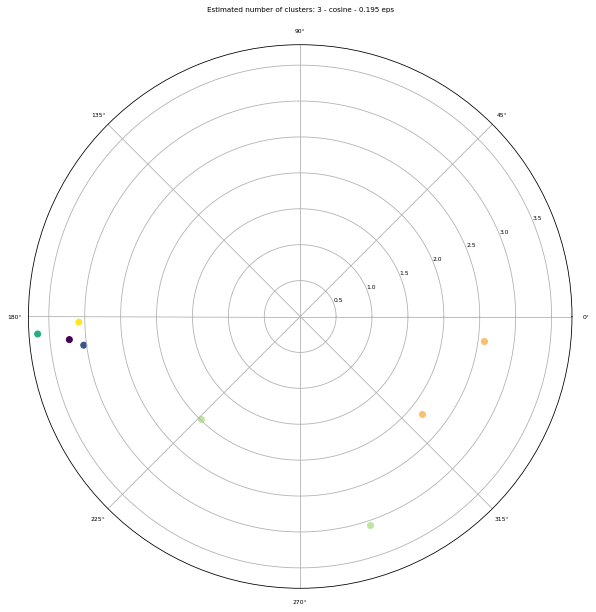


###############################################
Metric: euclidean
Eps: 5.9
Min Samples: 2
Estimated number of clusters: 1
Estimated number of noise points: 16


<Figure size 432x288 with 0 Axes>

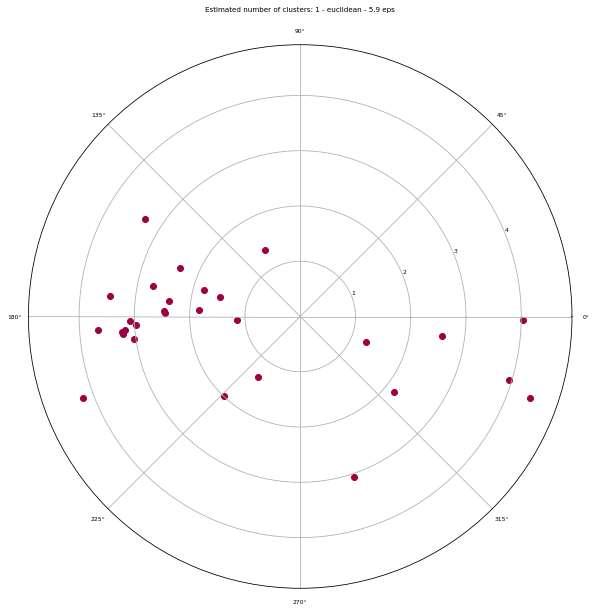

Total de ideas filtradas y procesadas: 12
Conteo de perfiles por cluster en progreso...
Ordenación por frecuencia por cluster en progreso
Calculo de clusters más relevantes en progreso...
[[1, 3], [2, 2]]


2019-05-09 15:47:40,959 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-05-09 15:47:40,960 : INFO : built Dictionary(37 unique tokens: ['hack', 'm.s.', 'graduation', 'technology', 'b.s.']...) from 6 documents (total 44 corpus positions)
2019-05-09 15:47:40,960 : INFO : collecting document frequencies
2019-05-09 15:47:40,961 : INFO : PROGRESS: processing document #0
2019-05-09 15:47:40,962 : INFO : calculating IDF weights for 6 documents and 36 features (44 matrix non-zeros)
2019-05-09 15:47:40,973 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-05-09 15:47:40,974 : INFO : built Dictionary(9 unique tokens: ['hands-on', 'leader', 'supervise', 'skilled', 'large']...) from 2 documents (total 9 corpus positions)
2019-05-09 15:47:40,974 : INFO : collecting document frequencies
2019-05-09 15:47:40,975 : INFO : PROGRESS: processing document #0
2019-05-09 15:47:40,976 : INFO : calculating IDF weights for 2 documents and 8 features (9 matrix non-zeros)
201

Almacenamiento de resultados en progreso...
Finalizado


<Figure size 432x288 with 0 Axes>

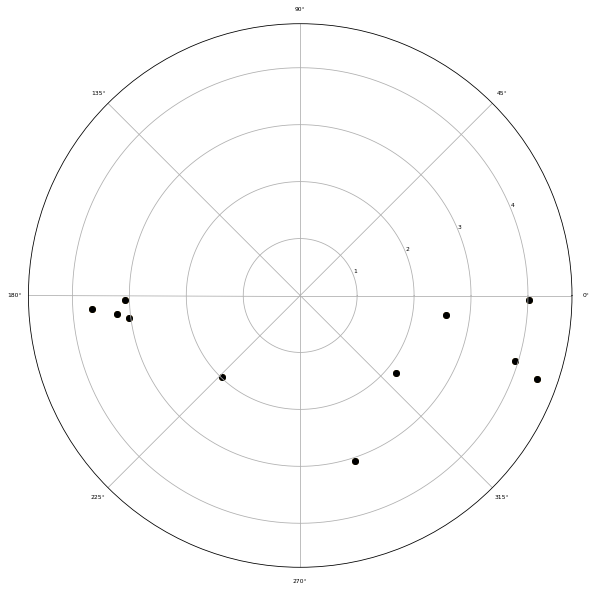

In [48]:
for i in range (3,4):
    
    ###############CREATE A DIRECTORY FOR EACH JOB###############################
    dirname =os.path.join(fprepath,SentenceSkillLinkedin[i][0][0].replace(" ","_"))

    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
    print("********************",SentenceSkillLinkedin[i][0][0],"********************")
    sent2Vec=[]
    cc=0
    for c,job in enumerate(SentenceSkillLinkedin[i]):
        for s in zip(job[2],job[3]):
            cc=cc+1
#             print([" ".join(s[0]),s[1]])
#             sent2Vec.append([" ".join(s[0]),s[1]])
            sent2Vec.append([s[0],s[1]])

    print("Total number of profiles processed: {}".format(c+1))
    print("Total number of sentences: {} - {}".format(len(sent2Vec),cc))
    jsenemb=[]
    jsentence=[]
    for js in sent2Vec:
        jsenemb.append(js[1])  
        jsentence.append(js[0])
        
    outfile = open(os.path.join(dirname,"sentenceEmbeding_{}.p".format(SentenceSkillLinkedin[i][0][0].replace(" ",""))),'wb')
    pickle.dump(jsenemb,outfile)
    outfile.close()
    
    outfile = open(os.path.join(dirname,"Sentence_{}.p".format(SentenceSkillLinkedin[i][0][0].replace(" ",""))),'wb')
    pickle.dump(jsentence,outfile)
    outfile.close()
         
    ##############################################################################
    ############                    Compute DBSCAN                   #############
    ##############################################################################
    
    minSamples=[2]
    eps = [0.195,5.9] #Euclidean: 4.82-3.97

    jsenemb = np.asarray(jsenemb)
    mets = ['cosine','euclidean']#,'canberra','hamming']#'euclidean'#'cosine'
    
    for met in mets:
        print("\n###############################################")
        print('Metric: %s' %met)
        for ep in eps:            
            if (met == 'cosine' and ep != eps[1]) or (met == 'euclidean' and ep != eps[0]):
                print('Eps: {}'.format(ep))
                for minsample in minSamples:
                    dbscan_model = DBSCAN(eps=ep, min_samples=minsample,metric=met)
                    x = dbscan_model.fit(jsenemb)
                    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
                    core_samples_mask[dbscan_model.core_sample_indices_] = True
#                     labels = dbscan_model.labels_
                    exec("labels_{}= dbscan_model.labels_".format(met))
    
                    exec("labels=labels_{}".format(met))

                # Number of clusters in labels, ignoring noise if present.
                    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                    n_noise_ = list(labels).count(-1)

                    print('Min Samples: {}'.format(minsample))
                    print('Estimated number of clusters: %d' % n_clusters_)
                    print('Estimated number of noise points: %d' % n_noise_)

                    #Calculation of Principal Component analysis
                    pca = PCA(n_components=2).fit(jsenemb)
                    datapoint = pca.transform(jsenemb)

                    #####################################################
                    ###                   Plot result                 ###
                    #####################################################
                    
                    unique_labels = set(labels)
                    colors = [plt.cm.Spectral(each)
                              for each in np.linspace(0, 1, len(unique_labels))]

                    fig = plt.figure(figsize=(20,10))
                    ax= fig.add_subplot(111,projection='polar')
#                     ax2 = fig.add_subplot(111,projection= 'rectilinear')

                    for k, col in zip(unique_labels, colors):
                        if k == -1:
                            # Black used for noise.
                            col = [0, 0, 0, 1]

                        class_member_mask = (labels == k)

                        xy = datapoint[class_member_mask & core_samples_mask]
                        polars=[]
                        for point in xy:
                            polar = cart2pol(point[0], point[1])
                            polars.append(polar)

                        r=[]
                        theta=[]
                        for cp in polars:
                            r.append(cp[0])
                            theta.append(cp[1])

#                         ax.set_rmax(0.012)
                        c = ax.scatter(theta, r,c=tuple(col),marker = 'o')
#                         d = ax2.scatter(theta,r,c=tuple(col),marker = 'o')
                        plt.rcParams.update({'font.size': 6})

#                         # Black removed and is used for noise instead.
#                         xy = datapoint[class_member_mask & ~core_samples_mask]
#                         polars=[]
#                         for point in xy:
#                             polar = cart2pol(point[0], point[1])
#                             polars.append(polar)

#                         r=[]
#                         theta=[]
#                         for cp in polars:
#                             r.append(cp[0])
#                             theta.append(cp[1])

#                         cnp = ax.scatter(theta, r,c=tuple(col),marker=".")
#                         plt.rcParams.update({'font.size': 2})

##                         ax.legend(unique_labels)
##                         fig.show()

        #             plt.margins(x=0, y=-0.45)   # Values in (-0.5, 0.0) zooms in to center

                    plt.title('Estimated number of clusters: {} - {} - {} eps'.format(n_clusters_,met,ep))
                    plt.show()
                    plt.savefig(os.path.join(dirname,"PolarSkills_{}_{}_eps".format(n_clusters_,met)) + '.png', dpi = 300)
    
                    outfile = open(os.path.join(dirname,"labels_{}.p".format(met)),'wb')
                    exec("pickle.dump(labels_{},outfile)".format(met))
                    outfile.close()
                
    ####################################################################
    #############           SKILLS COMPUTATION           ###############
    ####################################################################
                    
    fnameCos ="labels_cosine.p"
    fnameEuc ="labels_euclidean.p"
    fnamesemb = "sentenceEmbeding_{}.p".format(SentenceSkillLinkedin[i][0][0].replace(" ",""))
    fnamessen = "Sentence_{}.p".format(SentenceSkillLinkedin[i][0][0].replace(" ",""))
    
    CosineLabels = unpicke_file(dirname,fnameCos)
    EuclideanLabels = unpicke_file(dirname,fnameEuc)
    skillEmb = unpicke_file(dirname,fnamesemb)
    skillSen = unpicke_file(dirname,fnamessen)
    
    #Discrimination of habilities by comparing the clusters generated by the DBSCAN
    newlist = []
    mas=0
    for n in range(len(skillSen)):
        if CosineLabels[n] != -1 and EuclideanLabels[n] !=-1:
            mas=mas+1
            if [CosineLabels[n],skillSen[n],skillEmb[n]] not  in newlist:
                newlist.append([CosineLabels[n],skillSen[n],skillEmb[n]])
                newlist

    print("Total de ideas filtradas y procesadas: {}".format(mas))
    
    orderedlist = sorted(newlist, key=lambda x:x[0])
    
    ####################################################################
    ######                                                      ########
    ######            PLOT (COSINE - EUCIDEAN CLUSTERS)         ########
    ######                                                      ########
    ####################################################################
    embOrderedList= []
    for ol in orderedlist:
        embOrderedList.append(ol[2])
    #Calculation of Principal Component analysis
#     pcaResult = PCA(n_components=2).fit(dfOrderedList[2])
    datapointResult = pca.transform(np.array(embOrderedList))
    
    unique_labels = set(CosineLabels)
    colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
    
    fig2 = plt.figure(figsize=(20,10))
    axfig2 = fig2.add_subplot(111,projection= 'polar')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (CosineLabels == k)

        xy = datapointResult
        
        polars=[]
        for point in xy:
            polar = cart2pol(point[0], point[1])
            polars.append(polar)

        r=[]
        theta=[]
        for cp in polars:
            r.append(cp[0])
            theta.append(cp[1])

        lod = axfig2.scatter(theta,r,c=tuple(col),marker = 'o')
        plt.rcParams.update({'font.size': 6})
    
    #List to control and count the clusters and skills to be analyzed
    print("Conteo de perfiles por cluster en progreso...")
    dfc = pd.DataFrame(orderedlist)
    clus = list(set(dfc[0]))
    cluster=[]
    for c,j in enumerate(SentenceSkillLinkedin[i]):
    #     print(c,"###############################################################")
        cluster1=[]
        for s in zip(j[2],j[3]):               
            for sc in clus:
                skbyclust=dfc[dfc[0]==sc].values.tolist()
                maxSim=0
                lblskill=""
                for sk in skbyclust:                
                    simskill=simil_cos(s[1],sk[2])

                    if simskill >maxSim and simskill>=0.805:
                        maxSim=simskill
                        lblskill=sk[1]

                if maxSim>0:
                    cluster1.append(sc)
        setclus=list(set(cluster1))
        cluster.extend(setclus)
#     print(cluster)
                    
#     lTotSkill=list(set(listSkills))
#     print(lTotSkill)
    
    #Frecuency by word in each cluster
    counterClustSkill=[]
    for cclr in clus:
        counterClustSkill.append([cclr,cluster.count(cclr)])
    print("Ordenación por frecuencia por cluster en progreso")            
    #Ordering of the list generated
    counterClustSkill.sort(key=lambda x:x[1], reverse = True)
#     print(counterClustSkill)

    #********************************************************************************
    #********************* Collection of skills*************************************
    print("Calculo de clusters más relevantes en progreso...")
    skillcat=bestOption(counterClustSkill,0.3,counterClustSkill[0][1],orderedlist)
    skillcat = pd.DataFrame(skillcat,columns=["Cluster Label","Cluster freq.","Overview","Category"])
    print("Almacenamiento de resultados en progreso...")
    skillcat.to_csv(os.path.join(dirname,"SentenceCategorization_{}.csv".format(SentenceSkillLinkedin[i][0][0].replace(" ",""))))
    print("Finalizado")

In [83]:
dfwordfreq=pd.DataFrame(lstwordClust)
dfwordfreq
cSentence = list(dfwordfreq[0]) #Overview of words of the cluster 
eGenIdea=infer_doc2vec(model,cSentence,single=True)

In [84]:
iClustSen=[]
for x,lcs in enumerate(lstknclus):
#     print(nltk.word_tokenize(lcs))
    inferc = infer_doc2vec(model,lcs,single=True)
    iClustSen.append([lcs,inferc])
    

In [85]:
maxSim=0
for ics in iClustSen:
    sim = simil_cos(eGenIdea,ics[1])
    if sim > maxSim:
        maxSim = sim
        maxSen = ics[0]

print(maxSim)
print(maxSen)

0.8191898334804794
['also', 'get', 'opportunity', 'analyze', 'online', 'program', 'cics/ims']


In [23]:
dfOrderedList= pd.DataFrame(orderedlist)

In [41]:
for n,s in enumerate(skillSen):
    print ("{}/{}/{}".format(skillSen[n],CosineLabels[n],EuclideanLabels[n]))

['15', 'years', 'qualified', 'leadership', 'experience', 'project', 'management', 'quality', 'assurance', 'qa', 'configuration', 'management', 'requirements', 'analysis', 'testing', 'evaluation']/-1/-1
['led', 'integrated', 'software', 'hardware', 'test', 'teams', 'multiple', 'projects']/-1/-1
['conducted', 'qa/audits', 'highly', 'regulated', 'industries', 'adhering', 'food', 'drug', 'administration', 'regulations', 'iso', '9001']/-1/-1
['extensive', 'experience', 'automated', 'installation', 'entry', 'system', 'aie', 'integrated', 'commercial', 'intrusion', 'detection', 'system', 'icids', 'bio-tech', 'medical', 'equipment', 'enterprise', 'system', 'website', 'testing', 'applications', 'graphic', 'user', 'interface', 'gui']/-1/-1
['participated', 'system', 'design', 'architecture', 'review']/-1/0
['areas', 'expertise']/-1/0
['full', 'range', 'qa', 'concepts']/-1/0
['project', 'management']/0/0
['scope', 'management']/0/0
['time', 'management', 'site', 'management']/-1/0
['fielding']/-1

In [44]:
for o in orderedlist:
    print("{}/{}".format(o[1],o[0]))

['project', 'management']/0
['scope', 'management']/0
['communications', 'management']/0
['configuration', 'management']/0
['cost', 'controlin', 'cmmi', 'level', 'iii', 'requirements']/1
['b.s.', 'information', 'systems', 'virginia', 'commonwealth', 'university', 'richmond', 'va', '2000']/1
['m.s.', 'information', 'technology', 'project', 'manager', 'strayer', 'university', 'alexandria', 'va', 'anticipated', 'graduation', '2017']/1
['b.a.', 'biology', 'old', 'dominion', 'university', 'norfolk', 'va', 'anticipated', 'graduation', '2017']/1
['entrusted', 'budgets', '10m']/1
['mentor', 'hackathon', 'mexico', 'city', 'february', '2016', 'hack', 'equality']/1
['education', 'certifications']/2
['hands-on', 'leader', 'skilled', 'supervising', 'large', 'electronic', 'installs']/2
